In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import scipy.integrate

In [2]:
def R2WoodsSaxon(r, c, a):
    if (r < 0):
        return 0
    else:
        return r * r / (1 + np.exp((r - c) / a))
    
def RMS(pdf):
    normFactor = 4 * np.pi * scipy.integrate.quad(pdf, 0, 20)[0]
    r2 = 4 * np.pi * scipy.integrate.quad(lambda r : pdf(r) * r ** 2, 0, 20)[0]
    
    return np.sqrt(r2 / normFactor)
    
def GenerateCoordinates(nNucleons, pdf, init=1.1, stepsize=2.9, iterations=10000):
    pos = np.array([init] * nNucleons)
    
    for i in range(iterations):
        for n in range(len(pos)):
            newpos = pos[n] + stepsize * np.random.normal()
            
            if (pdf(newpos) / pdf(pos[n]) > np.random.uniform()):
                pos[n] = newpos
    
    return pos

def GenerateCartesianFromRadial(radial):
    res = np.array([1.0, 1.0, 1.0])
    
    u0 = np.random.uniform()
    u1 = np.random.uniform()
    
    u0 = 1 - 2 * u0
    u1 = 2 * u1
    
    res[0] = radial * np.sqrt(1 - u0 ** 2) * np.cos(np.pi * u1)
    res[1] = radial * np.sqrt(1 - u0 ** 2) * np.sin(np.pi * u1)
    res[2] = radial * u0
    
    return res

# Calculate whether each nucleon is interacting
def CalculateInteractionMatrix(nucleusA, nucleusB, nucleonRadius, impactParameter):
    nucleusA['Hits'] = [False] * nucleusA['nNucleons']

    i = 0
    for nucleonPosA in nucleusA['Coords']:
        for nucleonPosB in nucleusB['Coords']:
            dx_trans = np.array([nucleonPosA[0] - nucleonPosB[0] - impactParameter, nucleonPosA[1] - nucleonPosB[1]])
            if (np.sum(dx_trans * dx_trans) ** 0.5) < (2 * nucleonRadius):
                #We hit
                nucleusA['Hits'][i] = True
                break
        i += 1

    nucleusB['Hits'] = [False] * nucleusB['nNucleons']

    i = 0
    for nucleonPosB in nucleusB['Coords']:
        for nucleonPosA in nucleusA['Coords']:
            dx_trans = np.array([nucleonPosA[0] - nucleonPosB[0] - impactParameter, nucleonPosA[1] - nucleonPosB[1]])
            if (np.sum(dx_trans * dx_trans) ** 0.5) < (2 * nucleonRadius):
                #We hit
                nucleusB['Hits'][i] = True
                break
        i += 1

def DrawLongitudinalProjection(nucleusA, nucleusB, nucleonRadius, impactParameter):
    fig, ax = plt.subplots()

    nucleusBCenter = np.array([5 * nucleusB['RMS'], impactParameter])

    ax.add_patch(matplotlib.patches.Circle(np.array([0,0]), nucleusA['RMS'], edgecolor=(0, 0, 0, 1), facecolor=(1, 1, 1, 0)))
    ax.add_patch(matplotlib.patches.Circle(nucleusBCenter, nucleusB['RMS'], edgecolor=(0, 0, 0, 1), facecolor=(1, 1, 1, 0)))
    
    ax.axhline(0, ls='dashed', c='gray', alpha=0.6, zorder=-2)
    ax.axhline(impactParameter, ls='dashed', c='gray', alpha=0.6, zorder=-2)
    
    horizontalPos = 2 * nucleusB['RMS'] + nucleusA['RMS'] / 2
    arrowEpsilon = 0.25
    
    ax.text(horizontalPos, impactParameter / 2, "b", ha="center", va="center", c='gray')
    ax.annotate("", [horizontalPos, impactParameter / 2 + arrowEpsilon], [horizontalPos, impactParameter], arrowprops=dict(arrowstyle='<-', color='gray'))
    ax.annotate("", [horizontalPos, impactParameter / 2 - arrowEpsilon], [horizontalPos, 0], arrowprops=dict(arrowstyle='<-', color='gray'))
    
    for (nucleonPos, hit) in zip(nucleusA['Coords'], nucleusA['Hits']):
        if hit:
            color = nucleusA['partColor']
        else:
            color = nucleusA['specColor']
        ax.add_patch(matplotlib.patches.Circle(np.array([nucleonPos[2], nucleonPos[0]]), nucleonRadius, ec=None, fc=color))

    for (nucleonPos, hit) in zip(nucleusB['Coords'], nucleusB['Hits']):
        if hit:
            color = nucleusB['partColor']
        else:
            color = nucleusB['specColor']
        ax.add_patch(matplotlib.patches.Circle(nucleusBCenter + np.array([nucleonPos[2], nucleonPos[0]]), nucleonRadius, ec=None, fc=color))

    plt.gca().set_aspect('equal', adjustable='box')
    ax.autoscale_view()

    ax.set_xlabel('Longitudinal Coordinate z (fm)')
    ax.set_ylabel('Tranverse Coordinate x (fm)')

    ax.arrow(nucleusBCenter[0], nucleusBCenter[1], -1.5 * nucleusB['RMS'], 0, width=0.15, zorder=-1, color='black')

    # Create dummy legend
    linestyles = ['-']
    labels = ['RMS Radius']
    dummies = [ax.plot([], [], ls=ls, label = label, c = 'black') for (ls, label) in zip(linestyles, labels)]
    ax.legend()

    plt.show()
    
def DrawTransverseProjection(nucleusA, nucleusB, nucleonRadius, impactParameter):
    fig, ax = plt.subplots()

    nucleusBCenter = np.array([impactParameter, 0])

    ax.add_patch(matplotlib.patches.Circle(np.array([0,0]), nucleusA['RMS'], edgecolor=(0, 0, 0, 1), facecolor=(1, 1, 1, 0)))
    ax.add_patch(matplotlib.patches.Circle(nucleusBCenter, nucleusB['RMS'], edgecolor=(0, 0, 0, 1), facecolor=(1, 1, 1, 0)))
    
    #lineheight = nucleusA['RMS'] if nucleusA['RMS'] > nucleusB['RMS'] else nucleusB['RMS']
    #lineheight *= 1.7
    lineheight = 0
    arrowEpsilon = 0.1
    
    ax.axvline(0, ls='dashed', c='gray', zorder=-2)
    ax.axvline(impactParameter, ls='dashed', c='gray', zorder=-2)
    
    text = ax.text(impactParameter / 2, lineheight, "b", ha="center", va="center", c='gray')
    ax.annotate("", [impactParameter / 2 + arrowEpsilon, lineheight], [impactParameter, lineheight], arrowprops=dict(arrowstyle='<-', color='gray'))
    ax.annotate("", [impactParameter / 2 - arrowEpsilon, lineheight], [0, lineheight], arrowprops=dict(arrowstyle='<-', color='gray'))
    
    for (nucleonPos, hit) in zip(nucleusA['Coords'], nucleusA['Hits']):
        if hit:
            color = nucleusA['partColor']
        else:
            color = nucleusA['specColor']
        ax.add_patch(matplotlib.patches.Circle(np.array([nucleonPos[0], nucleonPos[1]]), nucleonRadius, ec=None, fc=color))

    for (nucleonPos, hit) in zip(nucleusB['Coords'], nucleusB['Hits']):
        if hit:
            color = nucleusB['partColor']
        else:
            color = nucleusB['specColor']
        ax.add_patch(matplotlib.patches.Circle(nucleusBCenter + np.array([nucleonPos[0], nucleonPos[1]]), nucleonRadius, ec=None, fc=color))

    ax.set_xlabel('Tranverse Coordinate x (fm)')
    ax.set_ylabel('Tranverse Coordinate y (fm)')

    # Create dummy legend
    linestyles = ['-']
    labels = ['RMS Radius']
    dummies = [ax.plot([], [], ls=ls, label = label, c = 'black') for (ls, label) in zip(linestyles, labels)]
    ax.legend()
    
    plt.gca().set_aspect('equal', adjustable='box')
    ax.autoscale_view()

    plt.show()

In [3]:
nucleusA = {}
nucleusB = {}

nucleusA['nNucleons'] = 24
nucleusB['nNucleons'] = 24

pdf = lambda r : R2WoodsSaxon(r, 3, 0.54)

nucleusA['pdf'] = pdf
nucleusB['pdf'] = pdf

nucleusA['RMS'] = RMS(pdf)
nucleusB['RMS'] = RMS(pdf)

nucleusA['Coords'] = np.array(list(map(GenerateCartesianFromRadial, GenerateCoordinates(nucleusA['nNucleons'], nucleusA['pdf']))))
nucleusB['Coords'] = np.array(list(map(GenerateCartesianFromRadial, GenerateCoordinates(nucleusB['nNucleons'], nucleusB['pdf']))))

nucleusA['Hits'] = [False] * nucleusA['nNucleons']
nucleusB['Hits'] = [False] * nucleusB['nNucleons']

In [4]:
nucleusA['specColor'] = list(matplotlib.colors.to_rgba('cornflowerblue'))
nucleusA['specColor'][-1] = 0.2
nucleusA['specColor'] = tuple(nucleusA['specColor'])

nucleusA['partColor'] = list(matplotlib.colors.to_rgba('springgreen'))
nucleusA['partColor'] = list(matplotlib.colors.to_rgba('cornflowerblue'))
nucleusA['partColor'][-1] = 0.2
nucleusA['partColor'] = tuple(nucleusA['partColor'])

nucleusB['specColor'] = list(matplotlib.colors.to_rgba('lightcoral'))
nucleusB['specColor'][-1] = 0.2
nucleusB['specColor'] = tuple(nucleusB['specColor'])

nucleusB['partColor'] = list(matplotlib.colors.to_rgba('sandybrown'))
nucleusB['partColor'] = list(matplotlib.colors.to_rgba('lightcoral'))
nucleusB['partColor'][-1] = 0.2
nucleusB['partColor'] = tuple(nucleusB['partColor'])

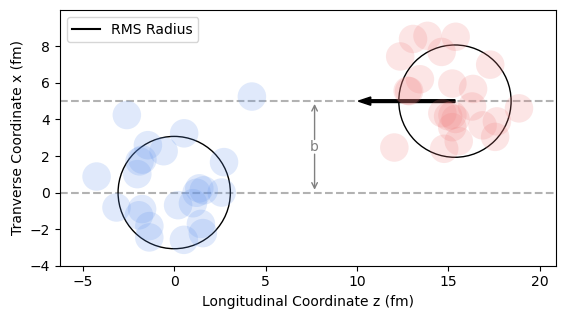

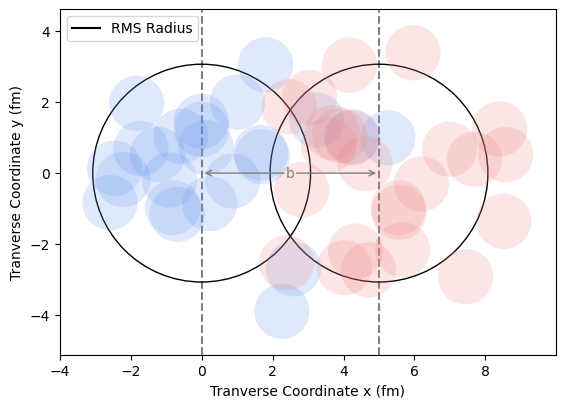

In [5]:
impactParameter = 5
sigmaNN = 43 #mb

nucleonRadius = np.sqrt(sigmaNN / 10 / np.pi) / 1.5

CalculateInteractionMatrix(nucleusA, nucleusB, nucleonRadius, impactParameter)
DrawLongitudinalProjection(nucleusA, nucleusB, nucleonRadius, impactParameter)
DrawTransverseProjection(nucleusA, nucleusB, nucleonRadius, impactParameter)